# ARIMA

Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Load dataset hasil Preprocessing

In [ ]:
data = pd.read_csv('data.csv')
data.head()

,Tahun,Bulan,Indeks,Tanggal,Kuartal
0,2014,Januari,89.03,2014-01-01,Q1
1,2015,Januari,76.49,2015-01-01,Q1
2,2016,Januari,62.10,2016-01-01,Q1
3,2017,Januari,88.43,2017-01-01,Q1
4,2018,Januari,100.00,2018-01-01,Q1


Data understanding

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tahun    120 non-null    int64  
 1   Bulan    120 non-null    object 
 2   Indeks   120 non-null    float64
 3   Tanggal  120 non-null    object 
 4   Kuartal  120 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.8+ KB


Mengubah kolom `Tanggal` menjadi format datetime, agar bisa dipakai sebagai index time series.

In [ ]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'])

Menjadikan kolom Tanggal sebagai indeks baris (syarat untuk analisis time series). Menyortir berdasarkan waktu agar urutan kronologis data terjaga.

In [ ]:
data.set_index('Tanggal', inplace=True)
data.sort_index(inplace=True)

Data dibagi 80% untuk training dan 20% untuk testing. Tujuannya untuk melatih model pada data historis dan mengujinya pada data terbaru.

In [ ]:
test_size = 0.2
split_point = int(len(data) * (1 - test_size))

train = data[:split_point]
test = data[split_point:]

print(f"Training data: {len(train)}")
print(f"Testing data: {len(test)}")


Training data: 96
Testing data: 24


Uji Stasioneritas (ADF Test). P-value < 0.05, maka data stasioner (tidak perlu diferensiasi).

In [ ]:
result = adfuller(train['Indeks'].dropna())
print("ADF Test setelah differencing 1x")
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')
if result[1] < 0.05:
    print("Data sudah stasioner")
else:
    print("Data belum stasioner")

ADF Test setelah differencing 1x
ADF Statistic: -0.9939605425566819
p-value: 0.755460675887667
Critical Value 1%: -3.5019123847798657
Critical Value 5%: -2.892815255482889
Critical Value 10%: -2.583453861475781
Data belum stasioner


Plot ACF dan PACF. Membantu menentukan parameter q (ACF) dan p (PACF) untuk ARIMA. Grafik digunakan sebagai panduan untuk memilih order (p, d, q).

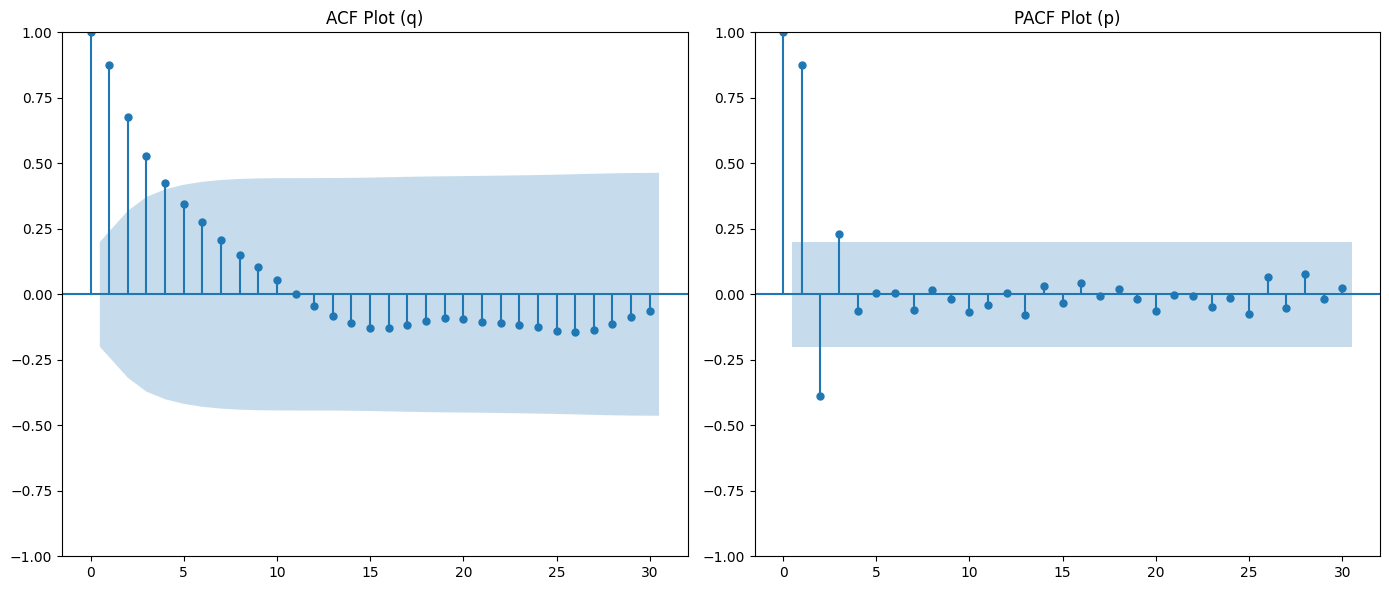

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(train['Indeks'], lags=30, ax=plt.gca())
plt.title('ACF Plot (q)')

plt.subplot(1, 2, 2)
plot_pacf(train['Indeks'], lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF Plot (p)')

plt.tight_layout()
plt.show()

Proses pencarian parameter optimal untuk model ARIMA dilakukan melalui grid search, yaitu dengan mencoba berbagai kombinasi nilai p, d, dan q. Kombinasi yang terbaik ditentukan berdasarkan nilai AIC (Akaike Information Criterion) terendah, karena semakin kecil nilai AIC, menunjukkan model semakin baik. Dalam proses pencarian ini, tidak perlu melakukan diferensiasi manual terhadap data, karena model ARIMA akan secara otomatis menanganinya selama proses pemodelan.

In [ ]:
best_aic = float('inf')
best_order = None
best_model = None

for p in range(6):
    for d in range(3):
        for q in range(6):
            try:
                model_arima = ARIMA(train['Indeks'], order=(p,d,q)).fit()
                if model_arima.aic < best_aic:
                    best_aic = model_arima.aic
                    best_order = (p,d,q)
                    best_model = model_arima
            except:
                continue

print(f"Best ARIMA order: {best_order} dengan AIC: {best_aic}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Best ARIMA order: (0, 2, 2) dengan AIC: 651.1267714091246


Forecast Menggunakan Model ARIMA

In [ ]:
n_future = len(test)
arima_model = best_model
arima_pred = arima_model.forecast(steps=n_future)
arima_ci = arima_model.get_forecast(steps=n_future).conf_int()

Evaluasi Model ARIMA

In [ ]:
arima_mse = (mean_squared_error(test['Indeks'], arima_pred))
arima_rmse = np.sqrt(arima_mse)
mae = mean_absolute_error(test['Indeks'], arima_pred)
mape = mean_absolute_percentage_error(test['Indeks'], arima_pred)

print("Evaluasi Model ARIMA:")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2%}")
print(f"RMSE : {arima_rmse:.2f}")

Evaluasi Model ARIMA:
MAE  : 54.20
MAPE : 34.25%
RMSE : 66.36


Model ARIMA menunjukkan kinerja yang kurang memuaskan dalam memprediksi data yang tidak stabil atau dinamis. Dengan MAE 54.20, MAPE 34.25%, dan RMSE 66.36, hasil prediksi model memiliki kesalahan yang relatif besar. Hal ini menunjukkan bahwa model ARIMA mungkin tidak cocok untuk data yang mengandung pola tidak stabil atau fluktuasi yang signifikan, seperti data yang banyak dipengaruhi oleh faktor-faktor eksternal atau perubahan kondisi pasar yang tidak terduga.
Model ARIMA lebih tepat digunakan untuk data yang relatif statis atau data yang mempunyai pola yang jelas dan stabil. Untuk data yang tidak stabil atau dinamis, pertimbangan penggunaan model lain yang lebih fleksibel atau mampu menangani pola data yang lebih kompleks dapat menjadi solusi yang lebih baik. Selain itu, mungkin juga diperlukan perbaikan atau modifikasi model, seperti transformasi data atau penambahan variabel eksternal, agar model dapat memberikan hasil prediksi yang lebih akurat.

Visualisasi Hasil Prediksi ARIMA

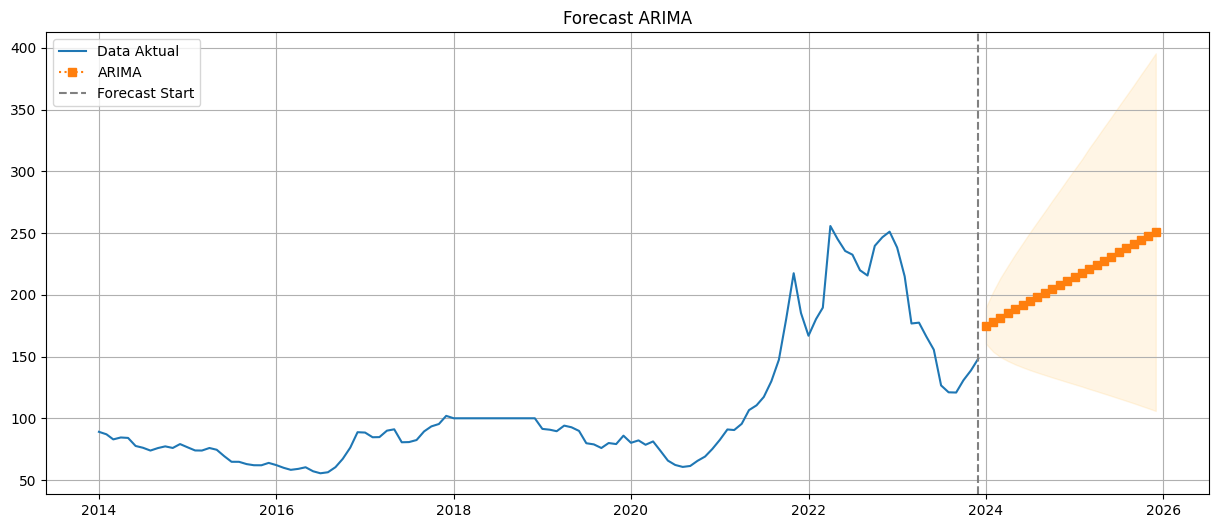

In [ ]:
data.index = pd.to_datetime(data.index)
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=n_future, freq='MS')

plt.figure(figsize=(15,6))
plt.plot(data.index, data['Indeks'], label="Data Aktual")
plt.plot(future_dates, arima_pred, label="ARIMA", linestyle=':', marker='s')
plt.fill_between(future_dates, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='orange', alpha=0.1)

plt.axvline(x=data.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title("Forecast ARIMA")
plt.legend()
plt.grid(True)
plt.show()

# LSTM

Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

Load dataset hasil Preprocessing

In [ ]:
data = pd.read_csv('data.csv')
data.head()

,Tahun,Bulan,Indeks,Tanggal,Kuartal
0,2014,Januari,89.03,2014-01-01,Q1
1,2015,Januari,76.49,2015-01-01,Q1
2,2016,Januari,62.10,2016-01-01,Q1
3,2017,Januari,88.43,2017-01-01,Q1
4,2018,Januari,100.00,2018-01-01,Q1


Data understanding

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tahun    120 non-null    int64  
 1   Bulan    120 non-null    object 
 2   Indeks   120 non-null    float64
 3   Tanggal  120 non-null    object 
 4   Kuartal  120 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.8+ KB


Mengubah kolom `Tanggal` menjadi format datetime, agar bisa dipakai sebagai index time series.

In [ ]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'])

Menjadikan kolom Tanggal sebagai indeks baris (syarat untuk analisis time series). Menyortir berdasarkan waktu agar urutan kronologis data terjaga.

In [ ]:
data = data.sort_values('Tanggal')

data = data[['Tanggal', 'Indeks']].set_index('Tanggal')

Normalisasi data menggunakan MinMaxScaler untuk mempersiapkan data yang lebih baik untuk analisis dan pemodelan, meningkatkan kinerja model, serta memudahkan visualisasi dan interpretasi hasil.

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

Window Sequence agar model dapat mempelajari pola dari urutan data sebelumnya untuk memprediksi nilai berikutnya. Reshape yang dilakukan adalah untuk memenuhi persyaratan input dari LSTM yang memerlukan data berbentuk tiga dimensi.

In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 6
X, y = create_sequences(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))


Data dibagi 80% untuk training dan 20% untuk testing. Tujuannya untuk melatih model pada data historis dan mengujinya pada data terbaru.

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (91, 6, 1)
y_train shape: (91,)


Reshape Data

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91, 6, 1), (23, 6, 1), (91,), (23,))

Modeling LSTM

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=4, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0286
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 16/50
23/23 ━━━━━━━━━━━━

Forecast menggunakan model LSTM

In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Evaluasi Model LSTM

In [ ]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Tampilkan hasil
print("Evaluasi Model LSTM:")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2%}")
print(f"RMSE : {rmse:.2f}")


Evaluasi Model LSTM:
MAE  : 16.74
MAPE : 8.57%
RMSE : 23.67


Model LSTM menunjukkan kinerja yang jauh lebih baik dalam memprediksi data yang tidak stabil atau dinamis. Dengan MAE 16.74, MAPE 8.57%, dan RMSE 23.67, hasil prediksi model memiliki kesalahan yang jauh lebih kecil dibandingkan dengan model ARIMA. Hal ini menunjukkan bahwa model LSTM mampu menangani pola data yang kompleks dan fluktuatif, seperti data yang dipengaruhi oleh faktor-faktor eksternal atau perubahan kondisi pasar yang tidak terduga. Model LSTM lebih tepat digunakan untuk data yang tidak stabil atau dinamis karena arsitekturnya yang mampu menangkap dependensi jangka panjang dalam data.

Visualisasi Hasil Prediksi LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


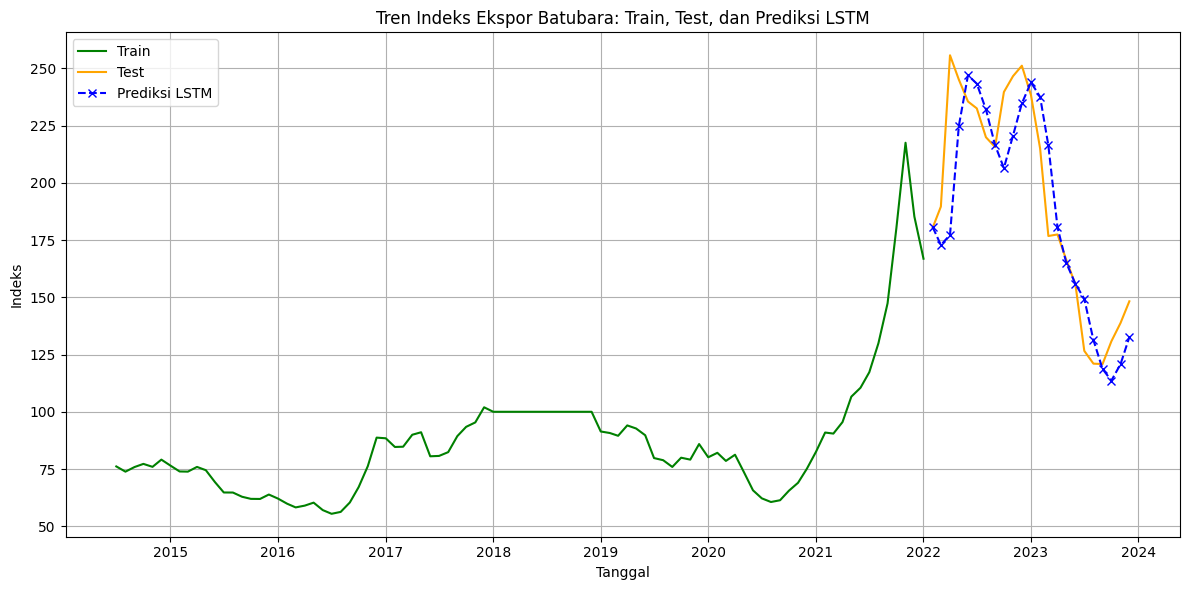

In [ ]:
tanggal_all = data.index[window_size:]
actual = scaler.inverse_transform(y.reshape(-1, 1))
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(model.predict(X_test))
aktual_train = actual[:train_size]
aktual_test = actual[train_size:]

plt.figure(figsize=(12, 6))
plt.plot(tanggal_all[:train_size], aktual_train, label='Train', color='green')
plt.plot(tanggal_all[train_size:], aktual_test, label='Test', color='orange')
plt.plot(tanggal_all[train_size:], y_pred, label='Prediksi LSTM', color='blue', linestyle='--', marker='x')

plt.title('Tren Indeks Ekspor Batubara: Train, Test, dan Prediksi LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Indeks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARIMA vs LSTM

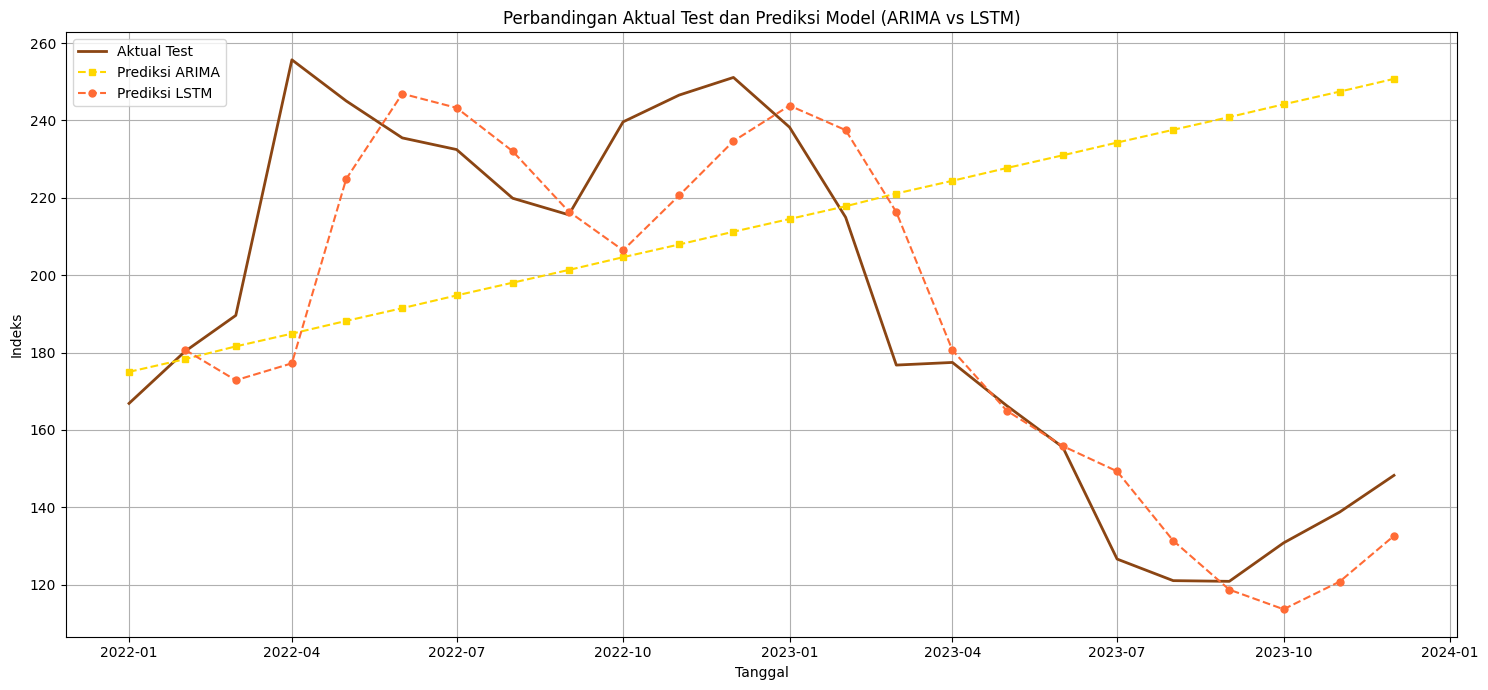

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Indeks'], label='Aktual Test', color='#8B4513', linewidth=2)
plt.plot(test.index, arima_pred, label='Prediksi ARIMA', color='#FFD700', linestyle='--', marker='s', markersize=5)
plt.plot(tanggal_all[train_size:], y_pred, label='Prediksi LSTM', color='#FF6B35', linestyle='--', marker='o', markersize=5)
plt.title('Perbandingan Aktual Test dan Prediksi Model (ARIMA vs LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Indeks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

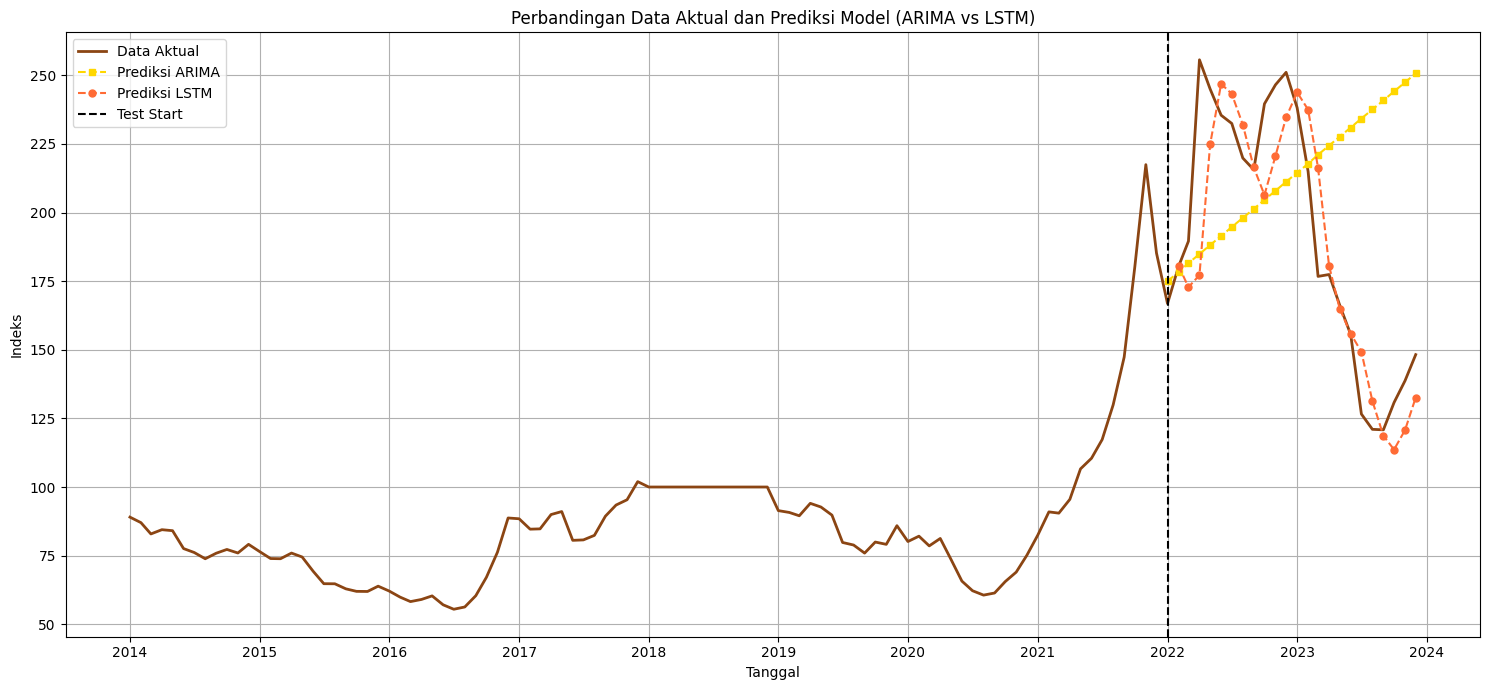

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Indeks'], label='Data Aktual', color='#8B4513', linewidth=2)
plt.plot(test.index, arima_pred, label='Prediksi ARIMA', color='#FFD700', linestyle='--', marker='s', markersize=5)
plt.plot(tanggal_all[train_size:], y_pred, label='Prediksi LSTM', color='#FF6B35', linestyle='--', marker='o', markersize=5)
plt.axvline(x=test.index[0], color='black', linestyle='--', label='Test Start')
plt.title('Perbandingan Data Aktual dan Prediksi Model (ARIMA vs LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Indeks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Kesimpulan

Analisis ekspor batubara Indonesia dilakukan melalui dua pendekatan, yaitu pendekatan teknis berbasis pemodelan prediktif, serta pendekatan struktural yang mengkaji dinamika faktor-faktor ekonomi dan geopolitik yang memengaruhi pergerakan harga dan volume ekspor.


## Pendekatan Teknis

Berdasarkan hasil pemodelan dan visualisasi prediksi, model Long Short-Term Memory (LSTM) menunjukkan kinerja yang lebih unggul dibandingkan model ARIMA dalam memprediksi indeks ekspor batubara Indonesia. Grafik perbandingan prediksi mengungkapkan bahwa:

- **LSTM** mampu menangkap fluktuasi kompleks dan pola musiman yang terdapat dalam data ekspor batubara secara lebih akurat.
- **LSTM** secara responsif mengikuti perubahan ekstrem, seperti lonjakan harga atau penurunan tajam, yang sering kali tidak dapat direpresentasikan oleh model berbasis linear seperti ARIMA.
- **ARIMA**, sebagai model statistik klasik, cenderung menghasilkan prediksi yang lebih datar dan linier, sehingga kurang mampu beradaptasi terhadap volatilitas pasar yang tinggi.

Dengan demikian, untuk data ekspor batubara Indonesia yang bersifat dinamis, dipengaruhi oleh faktor eksternal yang berubah cepat, dan memiliki pola non-linear yang kuat, pendekatan berbasis deep learning seperti **LSTM lebih direkomendasikan** untuk keperluan prediksi **jangka pendek** maupun **jangka menengah**.

## Pendekatan Struktural

Kajian terhadap pergerakan **Indeks Unit Value (IUV)** ekspor batubara Indonesia sepanjang tahun 2014–2024 mengungkapkan dinamika yang sangat dipengaruhi oleh konteks global dan kebijakan domestik:

- Periode **2021–2022** ditandai oleh lonjakan tajam IUV, yang dipicu oleh krisis energi global akibat ketegangan geopolitik (misalnya konflik Rusia-Ukraina), gangguan rantai pasok global, serta peningkatan permintaan energi fosil di tengah pemulihan pasca-pandemi.
- Sejak **2023**, terjadi tren penurunan IUV yang disebabkan oleh beberapa faktor:
  - **Oversupply** global sebagai akibat peningkatan produksi batubara domestik di negara-negara besar seperti China dan India.
  - **Percepatan transisi energi** menuju sumber energi terbarukan yang mengurangi permintaan global terhadap batubara.
  - **Penolakan pasar terhadap mekanisme Harga Batubara Acuan (HBA)** Indonesia yang dinilai kurang kompetitif dibanding harga pasar internasional.
- Selain itu, faktor-faktor tambahan seperti **fluktuasi nilai tukar** serta **kebijakan impor dari negara mitra dagang** (misalnya perubahan tarif, kuota, atau regulasi lingkungan) turut memperkuat volatilitas IUV ekspor batubara Indonesia.

## Kesimpulan Umum

Penggabungan temuan dari kedua pendekatan tersebut menunjukkan bahwa:

- Prediksi berbasis model LSTM dapat menjadi alat yang efektif bagi pemangku kepentingan (pemerintah, pelaku usaha, dan analis pasar) dalam memantau serta mengantisipasi pergerakan pasar ekspor batubara yang sangat volatil.
- Pemahaman terhadap faktor-faktor struktural global dan domestik tetap krusial sebagai landasan untuk interpretasi hasil prediksi dan penyusunan strategi kebijakan yang adaptif.
- Ke depan, integrasi pendekatan teknis (machine learning) dengan analisis struktural dapat meningkatkan akurasi dan relevansi prediksi serta membantu Indonesia dalam merespons dinamika pasar global secara lebih proaktif.

# Saran

Berdasarkan hasil analisis teknis dan struktural terhadap pergerakan ekspor batubara Indonesia, terdapat beberapa saran yang dapat dipertimbangkan untuk pengembangan riset lebih lanjut maupun untuk mendukung perumusan kebijakan yang lebih adaptif:

1. **Integrasi Faktor Eksternal dalam Model Prediksi**  
   Ke depannya, analisis Indeks Unit Value (IUV) ekspor batubara sebaiknya dikembangkan dengan memasukkan variabel-variabel eksternal yang memiliki pengaruh signifikan, seperti:
   - **Harga batubara global (misalnya indeks Newcastle)** sebagai acuan dinamika pasar internasional.
   - **Fluktuasi nilai tukar rupiah terhadap mata uang mitra dagang utama**, yang berdampak langsung pada daya saing harga ekspor.
   - **Kebijakan energi dan lingkungan di negara mitra dagang utama** (seperti Tiongkok, India, Jepang, dan Korea Selatan), termasuk regulasi terkait transisi energi, penetapan pajak karbon, dan kebijakan impor.

2. **Penguatan Evaluasi dan Penyesuaian Mekanisme HBA**  
   Mengingat adanya ketidakpuasan pasar terhadap mekanisme Harga Batubara Acuan (HBA) saat ini, diperlukan evaluasi mendalam atas metodologi penetapan HBA. Model prediksi berbasis LSTM yang telah terbukti lebih akurat dalam menangkap dinamika harga dapat diintegrasikan sebagai salah satu komponen referensi dalam proses evaluasi HBA agar lebih adaptif terhadap kondisi pasar global.

3. **Pengembangan Dashboard Pemantauan Dinamis**  
   Pemerintah dan pelaku usaha disarankan untuk membangun **dashboard pemantauan harga ekspor batubara** berbasis model prediktif yang diperbarui secara berkala, memanfaatkan teknologi machine learning. Dashboard ini dapat membantu:
   - Mengantisipasi fluktuasi harga jangka pendek dan menengah.
   - Mendukung pengambilan keputusan ekspor secara lebih responsif.
   - Memfasilitasi koordinasi lintas kementerian dan lembaga dalam perumusan kebijakan energi dan ekspor.

4. **Penguatan Kolaborasi Riset dan Data Sharing**  
   Diperlukan peningkatan kolaborasi antara lembaga statistik, kementerian terkait, pelaku industri, dan kalangan akademisi dalam:
   - Penyediaan data yang lebih lengkap, akurat, dan real-time.
   - Pengembangan model prediksi yang lebih canggih (misalnya hybrid model antara LSTM dan model ekonometrik).
   - Analisis skenario untuk menghadapi ketidakpastian pasar ke depan.

5. **Antisipasi Tren Transisi Energi Global**  
   Dengan semakin cepatnya transisi menuju energi terbarukan, Indonesia perlu:
   - Memetakan prospek pasar ekspor batubara di tengah penurunan permintaan global.
   - Menyiapkan strategi diversifikasi pasar dan produk (misalnya batubara yang lebih ramah lingkungan atau pengembangan pasar domestik).
   - Menyelaraskan strategi ekspor batubara dengan roadmap transisi energi nasional.
